<a href="https://colab.research.google.com/github/alexandrosXe/Speaker-Recognition/blob/main/Ethnicity_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/Speaker_Recognition

Mounted at /content/drive
/content/drive/MyDrive/Speaker_Recognition


# Imports and Constants

In [ ]:
%tensorflow_version 2.x
!pip install soundfile
!pip install python_speech_features

  Created wheel for python-speech-features: filename=python_speech_features-0.6-cp36-none-any.whl size=5890 sha256=a3ccdb686ea0c5ccec307fe3e8e69401cbe47b83c9e68dacd607519ed1018503
  Stored in directory: /root/.cache/pip/wheels/3c/42/7c/f60e9d1b40015cd69b213ad90f7c18a9264cd745b9888134be
Successfully built python-speech-features


In [ ]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"]="0"
import tensorflow as tf
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

import shutil
import scipy
import numpy as np
from tqdm import tqdm
from itertools import count
from collections import defaultdict
import soundfile as sf
import pandas as pd
from copy import deepcopy
from pathlib import Path
from sklearn.model_selection import train_test_split
from multiprocessing import Pool
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from scipy import stats #standard error of mean

from IPython.display import display, Audio
from python_speech_features import mfcc

from tensorflow import keras
from keras.metrics import categorical_accuracy
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Bidirectional, LSTM
import tensorflow.keras as keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import GRU, LSTM, Bidirectional, TimeDistributed
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import AveragePooling1D, AveragePooling2D, MaxPooling1D, MaxPooling2D, Flatten, Add, Conv1D, Conv2D
import tensorflow_addons as tfa

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5



In [ ]:
DATASET_ROOT = "archive/recordings"
#DATASET_INFO_PATH = "archive/speakers_all.csv"
DATASET_INFO_PATH = "/content/speakers_all.csv"
DATASET_MP3_PATH = DATASET_ROOT + "/recordings_mp3"
DATASET_WAV_PATH = DATASET_ROOT + "/recordings_wav"
DATASET_WAV_SPLITTED_PATH = DATASET_ROOT + "/recordings_wav_splitted"

# What we want to classify ('native_language', 'sex', 'speakerid' or 'country')
TO_CLASSIFY = 'native_language'

# Percentage of splits
VAL_SPLIT = 0.15
TEST_SPLIT = 0.15

# Seed to use when shuffling the dataset
SHUFFLE_SEED = 43

# The sampling rate to use of each file
SAMPLING_RATE = 44100
# The seconds of each file
SECONDS = 1
# Data are big, so we will pool while reading the files
POOL_SIZE = 10
PREPROCESSING = "FFT" # options: FFT, MFCC

#MODEL = "MLP" # options: CNN, MLP, BiLSTM, RESNET
BATCH_SIZE = 128
EPOCHS = 2000

# Convert files (from mp3 to Wav)

In [ ]:
# !pip install pydub

In [ ]:
# from pydub import AudioSegment
# from tqdm import tqdm

# if os.path.exists(DATASET_MP3_PATH):
#   for file in tqdm(os.listdir(DATASET_MP3_PATH)):
#     # files
#     src = DATASET_MP3_PATH+"/"+file
#     dst = DATASET_WAV_PATH+"/"+file[:-3]+"wav"

#     if os.path.exists(src) and not os.path.exists(dst):
#       # convert wav to mp3
#       sound = AudioSegment.from_mp3(src)
#       sound.export(dst, format="wav")

# Download dataset with users info

In [ ]:
!gdown --id 1sZOXsUb8LBWFXmTlo4BlAy60XSaDuvr6

Downloading...
From: https://drive.google.com/uc?id=1sZOXsUb8LBWFXmTlo4BlAy60XSaDuvr6
To: /content/speakers_all.csv
100% 161k/161k [00:00<00:00, 56.0MB/s]


# Feature Extraction

In [ ]:
# If preprocess == "MFCC", then the preprocessing doesn't use the variable 'pool_size'
def read_audio_file(path, label, sampling_rate, seconds, pool_size, preprocess):
  audio, rate = sf.read(path)
  #audio, rate = librosa.load(path, sr=sampling_rate) # This is a better option than pooling, but it's too slow

  if rate != sampling_rate:
    return [None, None]

  audios = []
  for i in range(0, len(audio)-len(audio)%(sampling_rate*seconds), sampling_rate*seconds):
    current_audio = audio[i:i+sampling_rate*seconds]
    if preprocess == "MFCC":
      mfcc_features = mfcc(current_audio,sampling_rate, nfft=1280)
      audios.append([mfcc_features, label])
    else:
      current_audio = np.expand_dims(np.expand_dims(current_audio, axis=-1), axis=0)
      # Pool to lower the dimenions of the data, since they are too big to be stored on RAM
      current_audio = AveragePooling1D(pool_size=pool_size, padding='valid')(current_audio)
      audios.append([np.squeeze(np.squeeze(current_audio, axis=-1), axis=0), label])

  return audios


def unpack(l):
  X = []
  y = []
  for item in l:
    if item == [None, None]:
      continue
    for item2 in item:
      X.append(item2[0])
      y.append(item2[1])
  return X, y


def audios_to_ffts(audios):
    audios = scipy.fft.fft(audios)
    audios = list(abs(audios[:, : len(audios[0]) // 2]))
    return audios


audio_paths = []
labels = []
label_names = []
#read data csv 

df = pd.read_csv(DATASET_INFO_PATH)
for index, row in df.iterrows():
  if not row['file_missing?']:
    audio_paths.append(DATASET_WAV_PATH + '/' + row['filename'] + '.wav')
    if row[TO_CLASSIFY] not in label_names:
      label_names.append(row[TO_CLASSIFY])
    labels.append(row[TO_CLASSIFY])

mapping = defaultdict(count().__next__)
labels = [mapping[tuple(str(element))] for element in labels]


# Read files (use threads to do it faster)
with Pool(20) as p:
  Xy = p.starmap(read_audio_file, tqdm([(audio_paths[i], labels[i], SAMPLING_RATE, SECONDS, POOL_SIZE, PREPROCESSING) for i in range(len(audio_paths))]))

X, y = unpack(Xy)
label_dict = {}
for i in range(len(label_names)-1, -1, -1):
  if i not in y:
    del label_names[i]
  else:
    label_dict[i] = label_names[i]

num_classes = len(set(y))
print("Number of classes: ", num_classes)

one_hot_labels = []
for item in y:
  one_hot_labels.append([0 if item != key else 1 for key in sorted(label_dict.keys())])

if  PREPROCESSING =="FFT":
    # Transform audio wave to the frequency domain
    X = audios_to_ffts(X)

100%|██████████| 2138/2138 [01:01<00:00, 34.70it/s]


Number of classes:  193


# Model Definition

In [ ]:
# for rnn output (when we take all its hidden states and want to Pool from them)
class MyAtt(keras.layers.Layer):
  def __init__(self, weight_size = 50, to_print = False):
    super(MyAtt, self).__init__()
    self.to_print = to_print
    self.weight_size = weight_size

  def get_config(self):
    config = super().get_config().copy()
    config.update({
        'to_print': self.to_print,
        'weight_size': self.weight_size,
    })
    return config

  def build(self, input_shape):
    self.w = self.add_weight(
        shape=(self.weight_size,input_shape[-1]),
        initializer="random_normal",
        trainable=True,
        name="AttW"
    )
    self.v = self.add_weight(
        shape=(self.weight_size,),
        initializer="random_normal",
        trainable=True,
        name="Attv"
    )
  
  def call(self, input):
    if self.to_print:
      tf.print("INPUT:", input, "\n")
      for i in range(tf.shape(input)[0]):
        for j in range(input.shape[1]):
          row = input[i,j,:]
          tf.print("ROW:", row)
        tf.print()

    weights = tf.einsum('w,...wl->...l', self.v, tf.math.tanh(tf.einsum('we,ble->bwl', self.w, input)))
    if self.to_print: tf.print("WEIGHTS:", weights)

    att_weights = tf.nn.softmax(weights)
    if self.to_print: tf.print("\nWEIGHTS AFTER SOFTMAX:", att_weights, "\n")

    output = tf.einsum('...l,...lk->...k', att_weights, input) # 2x3, 2x3x4 to 2x4
    if self.to_print: tf.print("OUTPUT:", output, "\n")

    return output

In [ ]:
def CNN(input_shape, num_classes):
  inputs = Input(shape=input_shape, name="input")
  conv = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
  batch = BatchNormalization()(conv)
  pool = AveragePooling2D((2, 1), padding='same')(batch)
  for i in range(2):
    conv = Conv2D(64, (3, 3), activation='relu', padding='same')(pool)
    batch = BatchNormalization()(conv)
    pool = AveragePooling2D((2, 1), padding='same')(batch)
  conv = Conv2D(64, (3, 3), activation='relu', padding='same')(pool)
  batch = BatchNormalization()(conv)
  pool = AveragePooling2D((2, 2), padding='same')(batch)
  conv = Conv2D(64, (3, 3), activation='relu', padding='same')(pool)
  batch = BatchNormalization()(conv)
  flat = Flatten()(batch)
  drop = Dropout(0.5)(flat)
  dense = Dense(256, activation='relu')(drop)
  batch = BatchNormalization()(dense)
  drop = Dropout(0.5)(batch)
  output = Dense(num_classes, activation = 'softmax')(drop)
  model = Model(inputs, output)
  return model

def MLP(input_shape, num_classes):
  inputs = Input(shape=input_shape, name="input")
  drop = Dropout(0.5)(inputs)
  dense = Dense(1024, activation = 'relu')(drop)
  dense = BatchNormalization()(dense)
  dense = Dense(512, activation = 'relu')(dense)
  drop2 = Dropout(0.5)(dense)
  dense = Dense(256, activation = 'relu')(drop2)
  dense = BatchNormalization()(dense)
  output = Dense(num_classes, activation = 'softmax')(dense)
  model = Model(inputs, output)
  return model

def BiLSTM(input_shape, num_classes, stacks=4):
    inputs = Input(shape=input_shape, name="input")
    #flat = Flatten()(inputs)
    #x = tf.reshape(inputs, [-1, splits, inputs.shape[1]//(splits)])
    x = Dense(128, activation = 'relu')(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.7)(x)
    #conv = Conv1D(128, 3, activation='relu', padding = 'same')(reshaped)
    #pooled = AveragePooling1D(4)(conv)
    for i in range(stacks):
      x = Bidirectional(LSTM(units=128, return_sequences=True))(x)
    #x = Bidirectional(LSTM(units=128, return_sequences=False))(x)
    x = MyAtt()(x)
    x = Dense(256, activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.7)(x)
    #att = MyAtt()(x2)
    outputs = Dense(num_classes, activation = 'softmax')(x)
    model = Model(inputs=inputs, outputs= outputs)
    return model

def residual_block(x, filters, conv_num=3, activation="elu"):
    # Shortcut
    s = Conv1D(filters, 1, padding="same")(x)
    for i in range(conv_num - 1):
        x = Conv1D(filters, 3, padding="same")(x)
        x = Activation(activation)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Conv1D(filters, 3, padding="same")(x)
    x = Add()([x, s])
    x = Activation(activation)(x)
    return MaxPooling1D(pool_size=2, strides=2)(x)

def RESNET(input_shape, num_classes):
    inputs = Input(shape=input_shape, name="input")

    x = residual_block(inputs, 16, 2)
    x = residual_block(x, 32, 2)
    x = residual_block(x, 64, 3)
    x = residual_block(x, 128, 3)
    x = residual_block(x, 128, 3)

    x = AveragePooling1D(pool_size=3, strides=3)(x)
    x = Flatten()(x)
    x = Dense(256, activation="relu")(x)
    x = Dense(128, activation="relu")(x)

    outputs = Dense(num_classes, activation="softmax", name="output")(x)

    return keras.models.Model(inputs=inputs, outputs=outputs)

* Fit Model

In [ ]:
def column_stats(l, column):
  temp = []
  for item in l:
    temp.append(item[column])
  return 'mean = ' + str(np.mean(temp)) + ' sem = ' + str(stats.sem(temp))

def my_flatten(l):
  for i in range(len(l)):
    l[i] = [item for sublist in l[i] for item in sublist]
  return l

def my_reshape(l, splits = 105):
  for i in range(len(l)):
    #l[i] = tf.reshape(l[i], [splits, int(len(l[i])/splits)])
    l[i] = np.reshape(l[i], (splits, int(len(l[i])/splits)))

  return l

def plot_history(hs, epochs, metrics):
    print()
    plt.style.use('dark_background')
    plt.rcParams['figure.figsize'] = [10, 6]
    plt.rcParams['font.size'] = 16
    plt.clf()
    for label in hs:
      for metric in metrics:
        plt.plot(hs[label].history[metric], label='{0:s} train {1:s}'.format(label, metric), linewidth=5)
        plt.plot(hs[label].history['val_{0:s}'.format(metric)], label='{0:s} validation {1:s}'.format(label, metric), linewidth=5)
    x_ticks = np.arange(0, epochs+1, 10)
    plt.xticks(ticks=x_ticks, labels=x_ticks)
    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    plt.legend()
    plt.show()


def display_mistakes(X_test, model_name, model, SAMPLES_TO_DISPLAY = 10):

  index = 0
  displayed = 0
  while displayed != SAMPLES_TO_DISPLAY:
      audio = X_test[index:index+1]
      if model_name == "CNN" or model_name == "RESNET":
        audio = np.expand_dims(audio, axis=-1)
      #print(len(audio))
      label = y_test[index]

      # Predict
      y_pred = model.predict(audio)[0]

      # For every false predicted sample, print the true and predicted label
      if np.argmax(label) != np.argmax(y_pred):
        displayed += 1
        print(
            "Speaker: {} - Predicted: {}".format(
                label_names[np.argmax(label)],
                label_names[np.argmax(y_pred)],
            )
        )
        print(np.argmax(label), np.argmax(y_pred))
        #display(Audio(audios[index, :, :].squeeze(), rate=SAMPLING_RATE))

      index += 1


def Run_Classifier(model_name, preprocess_name, metrics, X, k_fold=3):


  train_list = []
  val_list = []
  test_list = []
    
  if preprocess_name == "MFCC" and (model_name == "MLP" or model_name == "RESNET"):
    X = my_flatten(X)
  elif preprocess_name == "FFT" and (model_name != "MLP" and model_name != "RESNET"):
    X = my_reshape(X)

  for i in range(k_fold):
    
    X_train, X_temp, y_train, y_temp = train_test_split(X, one_hot_labels, test_size=(TEST_SPLIT+VAL_SPLIT), random_state=SHUFFLE_SEED+i, stratify = y)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=(TEST_SPLIT/(TEST_SPLIT+VAL_SPLIT)), random_state=SHUFFLE_SEED+i, stratify = y_temp)

    if model_name == "CNN":
      model = CNN((X_train[0].shape[0], X_train[0].shape[1], 1), num_classes)
    elif model_name == "MLP":
      model = MLP(len(X_train[0]), num_classes)
    elif model_name == "BiLSTM":
      model = BiLSTM((X_train[0].shape[0], X_train[0].shape[1]), num_classes)
    elif model_name == "RESNET":
      model = RESNET((len(X_train[0]), 1), num_classes)
    
    model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.Adam(learning_rate=0.001),
                  metrics= metrics)

    model.summary()

    history = model.fit(
        np.array(X_train),
        np.array(y_train),
        epochs=2000,
        batch_size = 128,
        validation_data= (np.array(X_val), np.array(y_val)),
        callbacks= EarlyStopping(monitor="val_f1_score",
                                mode="max",
                                verbose=1,
                                patience=10,
                                restore_best_weights=True))
    


    print("TRAIN SCORES:")
    train_list.append(model.evaluate(np.array(X_train), np.array(y_train)))

    print("VAL SCORES:")
    val_list.append(model.evaluate(np.array(X_val), np.array(y_val)))

    print("TEST SCORES:")
    test_list.append(model.evaluate(np.array(X_test), np.array(y_test)))


  #display_mistakes(X_test, model_name, model, 10)
  
  plot_history({model_name: history}, len(history.history['categorical_accuracy']), ['categorical_accuracy', 'f1_score'])

  print("k-Fold scores:")
  print("TRAIN:\taccuracy:", column_stats(train_list,1), "\t\tand f1:", column_stats(train_list,2))
  print("VAL:\taccuracy:", column_stats(val_list,1), "\t\tand f1:", column_stats(val_list,2))
  print("TEST:\taccuracy:", column_stats(test_list,1), "\t\tand f1:", column_stats(test_list,2))

* Run Experiments

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2205)]            0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2205)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              2258944   
_________________________________________________________________
batch_normalization_6 (Batch (None, 1024)              4096      
_________________________________________________________________
dense_3 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               1313

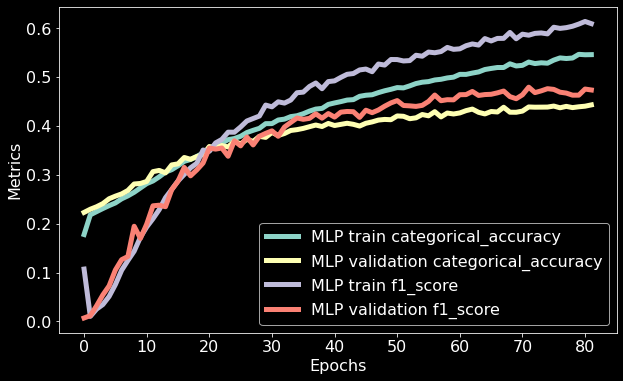

k-Fold scores:
TRAIN:	accuracy: mean = 0.826526920000712 sem = 0.02097551262271643 		and f1: mean = 0.9116122325261434 sem = 0.010215527788103853
VAL:	accuracy: mean = 0.4446054697036743 sem = 0.004148880769064099 		and f1: mean = 0.4912395775318146 sem = 0.006809741091934702
TEST:	accuracy: mean = 0.4452496071656545 sem = 0.002535590332819078 		and f1: mean = 0.47940335671106976 sem = 0.0047916848856747775
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 105, 21)]         0         
_________________________________________________________________
dense_14 (Dense)             (None, 105, 128)          2816      
_________________________________________________________________
batch_normalization_12 (Batc (None, 105, 128)          512       
_________________________________________________________________
dropout_8 (Dropout)          (None, 105, 128

KeyboardInterrupt: ignored

In [ ]:
metrics =[categorical_accuracy,
          tfa.metrics.F1Score(num_classes,'macro', None, 'f1_score'),
          keras.metrics.Precision(name='precision'),
          keras.metrics.Recall(name='recall')] 


Run_Classifier("MLP", PREPROCESSING, metrics, deepcopy(X), k_fold=3)
Run_Classifier("BiLSTM", PREPROCESSING, metrics, deepcopy(X), k_fold=3)
Run_Classifier("RESNET", PREPROCESSING, metrics, deepcopy(X), k_fold=3)
Run_Classifier("CNN", PREPROCESSING, metrics, deepcopy(X), k_fold=3)



# Graphs

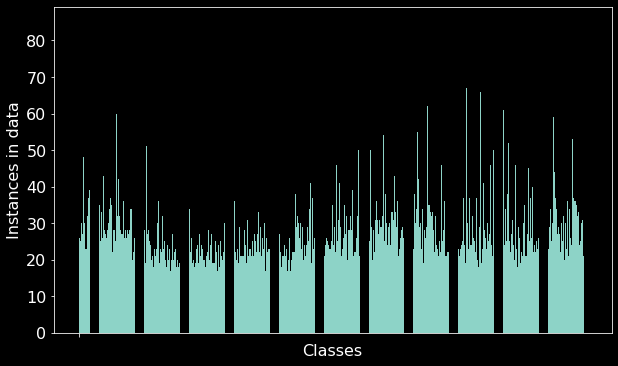

In [ ]:
D = {}
for item in one_hot_labels:
  string = label_names[np.argmax(item)]
  if string not in D:
    D[string] = 1
  else:
    D[string] += 1

plt.bar(range(len(D)), list(D.values()), align='center')
if TO_CLASSIFY == "sex":
  plt.xticks(range(len(D)), D.keys())
else:
  plt.xticks([1],[''])
plt.xlabel("Classes")
plt.ylabel("Instances in data")

plt.show()